In [3]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
import keras_nlp
np.set_printoptions(precision=4, suppress=True)
tf.config.set_visible_devices([], 'GPU') # Disable GPU Usage
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.15.0


In [4]:
# Load data
arr = np.loadtxt("/training.csv", delimiter=",")
x = arr[:,0:8]
y = arr[:,8:]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print('Training Input Shape: ', x_train.shape)
print('Training Output Shape: ', y_train.shape)
print('Testing Input Shape: ', x_test.shape)
print('Testing Output Shape: ', y_test.shape)

Training Input Shape:  (1505, 8)
Training Output Shape:  (1505, 3)
Testing Input Shape:  (377, 8)
Testing Output Shape:  (377, 3)


In [25]:
# Flipping the training samples that have \Delta y > 0
training_size = len(x_train)
x_train_processed = x_train.copy()
y_train_processed = y_train.copy()

for i in range(training_size):
    if x_train[i, 7] > 0:
        x_train_processed[i, 1] = -1 * x_train[i, 1] # Flip obstacle y-coordinates
        x_train_processed[i, 5] = -1 * x_train[i, 5] # Flip receiver y-coordinates
        x_train_processed[i, 7] = -1 * x_train[i, 7] # Flip \Delta y
        y_train_processed[i, 0] = -1 * y_train[i, 0] # Flip curving parameter
        y_train_processed[i, 2] = -1 * y_train[i, 2] # Flip steering adjustment

# Normalization of training data (recording the mean and standard deviation)
xmean = x_train_processed.mean(0)
xstd = x_train_processed.std(0)
x_train_processed -= xmean
x_train_processed /= xstd
ymean = y_train_processed.mean(0)
ystd = y_train_processed.std(0)
y_train_processed -= ymean
y_train_processed /= ystd

In [26]:
# Similarly, preprocess the test samples
testing_size = len(x_test)
x_test_processed = x_test.copy()
y_test_processed = y_test.copy()

for i in range(testing_size):
    if x_test[i, 7] > 0:
        x_test_processed[i, 1] = -1 * x_test_processed[i, 1] # Flip obstacle y-coordinates
        x_test_processed[i, 5] = -1 * x_test_processed[i, 5] # Flip receiver y-coordinates
        x_test_processed[i, 7] = -1 * x_test_processed[i, 7] # Flip \Delta y
        y_test_processed[i, 0] = -1 * y_test_processed[i, 0] # Flip curving parameter
        y_test_processed[i, 2] = -1 * y_test_processed[i, 2] # Flip steering adjustment

# Normalization of testing data (using mean and std learned from the training set)
x_test_processed -= xmean
x_test_processed /= xstd
y_test_processed -= ymean
y_test_processed /= ystd

In [27]:
# Linear best model

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(0.1),
  # tf.keras.layers.Dense(1024, activation='relu'),
  # tf.keras.layers.Dropout(0.17),
  tf.keras.layers.Dense(3)
])
model.compile(optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=0.008, momentum=0.8),
              loss=tf.keras.losses.MeanAbsoluteError())
model.fit(x_train_processed, y_train_processed, batch_size=64, epochs=500, validation_data=(x_test_processed, y_test_processed))

Epoch 1/500
24/24 [==============================] - 0s 10ms/step - loss: 0.7457 - val_loss: 0.7096
Epoch 2/500
24/24 [==============================] - 0s 7ms/step - loss: 0.7268 - val_loss: 0.6898
Epoch 3/500
24/24 [==============================] - 0s 7ms/step - loss: 0.7110 - val_loss: 0.6752
Epoch 4/500
24/24 [==============================] - 0s 7ms/step - loss: 0.6968 - val_loss: 0.6635
Epoch 5/500
24/24 [==============================] - 0s 7ms/step - loss: 0.6883 - val_loss: 0.6547
Epoch 6/500
24/24 [==============================] - 0s 7ms/step - loss: 0.6778 - val_loss: 0.6490
Epoch 7/500
24/24 [==============================] - 0s 7ms/step - loss: 0.6724 - val_loss: 0.6460
Epoch 8/500
24/24 [==============================] - 0s 7ms/step - loss: 0.6677 - val_loss: 0.6381
Epoch 9/500
24/24 [==============================] - 0s 7ms/step - loss: 0.6596 - val_loss: 0.6343
Epoch 10/500
24/24 [==============================] - 0s 7ms/step - loss: 0.6540 - val_loss: 0.6244
Epoch 11

In [35]:
# model = tf.keras.models.load_model('model.keras')
# model.summary()


In [28]:
y_pred = model.predict(x_test_processed)
y_pred_tr = model.predict(x_train_processed)

48/48 [==============================] - 0s 1ms/step


In [29]:
# Unnormalize data
y_pred = y_pred * ystd
y_pred = y_pred + ymean
y_pred_tr = y_pred_tr * ystd
y_pred_tr = y_pred_tr + ymean

for i in range(testing_size):
    if x_test[i, 7] > 0:
        y_pred[i, 0] = -1 * y_pred[i, 0] # Flip curving parameter
        y_pred[i, 2] = -1 * y_pred[i, 2] # Flip steering adjustment

for i in range(training_size):
    if x_train[i, 7] > 0:
        y_pred_tr[i, 0] = -1 * y_pred_tr[i, 0] # Flip curving parameter
        y_pred_tr[i, 2] = -1 * y_pred_tr[i, 2] # Flip steering adjustment

R2 score:  0.355397222190716
All R2:  0.355397222190716 0.535557802725831 0.8741570084379431
Total R2:  1.76511203335449


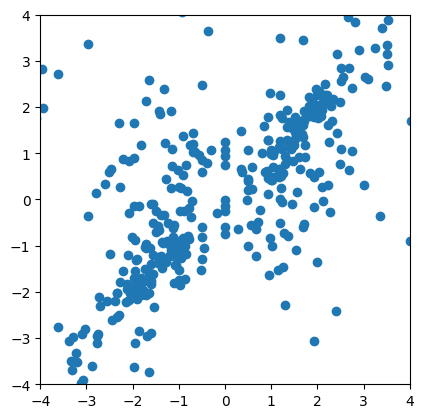

In [31]:
ind = 0
plt.scatter(y_test[:,ind], y_pred[:,ind])
plt.axis('square')
plt.xlim([-4, 4])
plt.ylim([-4, 4])
print('R2 score: ', r2_score(y_test[:,ind],y_pred[:,ind]))
print('All R2: ', r2_score(y_test[:,0],y_pred[:,0]), r2_score(y_test[:,1],y_pred[:,1]), r2_score(y_test[:,2],y_pred[:,2]))
print('Total R2: ', r2_score(y_test[:,0],y_pred[:,0]) + r2_score(y_test[:,1],y_pred[:,1]) + r2_score(y_test[:,2],y_pred[:,2]))

R2 score:  0.7685797424672981


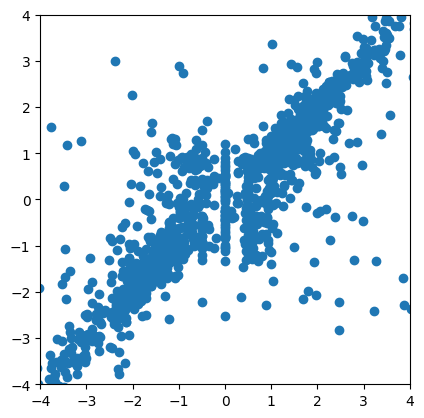

In [32]:
plt.scatter(y_train[:,0], y_pred_tr[:,0])
plt.axis('square')
plt.xlim([-4, 4])
plt.ylim([-4, 4])
print('R2 score: ',r2_score(y_train[:,0],y_pred_tr[:,0]))

(array([ 2.,  6.,  3., 13.,  7., 23., 28., 39., 29., 26., 20., 38., 42.,
        32., 27., 17.,  6.,  9.,  5.,  2.]),
 array([-4.5 , -4.05, -3.6 , -3.15, -2.7 , -2.25, -1.8 , -1.35, -0.9 ,
        -0.45,  0.  ,  0.45,  0.9 ,  1.35,  1.8 ,  2.25,  2.7 ,  3.15,
         3.6 ,  4.05,  4.5 ]),
 <BarContainer object of 20 artists>)

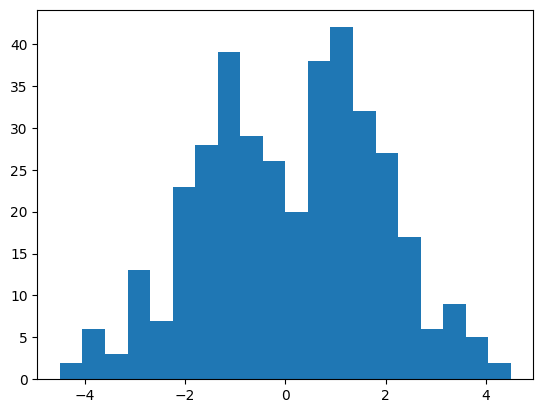

In [33]:
plt.hist(y_pred[:,0], bins=20, range=(-4.5,4.5))

(array([ 1.,  6.,  8., 12., 15., 34., 39., 46., 26.,  4., 13., 17., 48.,
        38., 33., 17.,  7.,  8.,  2.,  3.]),
 array([-4.5 , -4.05, -3.6 , -3.15, -2.7 , -2.25, -1.8 , -1.35, -0.9 ,
        -0.45,  0.  ,  0.45,  0.9 ,  1.35,  1.8 ,  2.25,  2.7 ,  3.15,
         3.6 ,  4.05,  4.5 ]),
 <BarContainer object of 20 artists>)

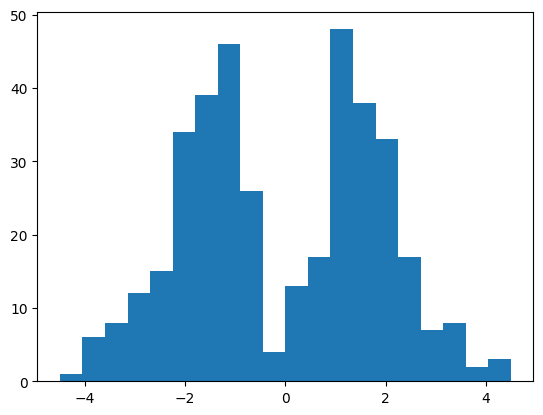

In [34]:
plt.hist(y_test[:,0], bins=20, range=(-4.5,4.5))

In [58]:
# For manual testing individual cases
manual_test = np.array([0.15, -0.06, 0.02, 0.08, 0.32, -0.08, 0.69652, 0.048])
manual_test = np.reshape(manual_test, (1,8))

In [59]:
manual_test_processed = manual_test.copy()
if manual_test[0][7] > 0:
        manual_test_processed[0][1] = -1 * manual_test_processed[0][1] # Flip obstacle y-coordinates
        manual_test_processed[0][5] = -1 * manual_test_processed[0][5] # Flip receiver y-coordinates
        manual_test_processed[0][7] = -1 * manual_test_processed[0][7] # Flip \Delta y
manual_test_processed -= xmean
manual_test_processed /= xstd
manual_pred = model.predict(manual_test_processed)
manual_pred = manual_pred * ystd
manual_pred = manual_pred + ymean
if manual_test[0][7] > 0:
        manual_pred[0][0] = -1 * manual_pred[0][0] # Flip curving parameter
        manual_pred[0][2] = -1 * manual_pred[0][2] # Flip steering adjustment

1/1 [==============================] - 0s 11ms/step


In [60]:
manual_pred

array([[ 4.7507, -0.1837,  8.0762]])